# IBM Developer Skills Network

## Capstone project for applied data science

- The problem to be solved in this project is to find a place to rent in Seoul, capital city of South Korea.

- The selection criteria will be based on rent price, desired location, transportation, entertainment, service, food, sport center ...
- Database for all building, apartment & house in Seoul can be found in the below link: https://www.juso.go.kr/addrlink/addressBuildDevNew.do?menu=match

- This database contains all detail location of all building, apartments and house in Seoul together with X, Y coordinates.
- Due to the size of the data (very large), only 1000 rows were randomly extracted to use in this analysis.

- K-Means classification & minimum Minkowski distance will be used to classify building & apartment.

In [74]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json  # handle json file

from geopy.geocoders import Nominatim  # convert address to lat and long
import requests  # handle request url
from pandas.io.json import json_normalize  # transform json to dataframe

import matplotlib.cm as cm  # color map handling
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
import folium  # map rendering

## # Load the seoul rent file

In [143]:
path = 'https://raw.githubusercontent.com/sonpn82/Coursera_Capstone/master/Seoul_rent_1000.csv'

seoul_data = pd.read_csv(path, encoding='cp949')
seoul_data = seoul_data.sample(200)
seoul_data.shape

(200, 19)

In [99]:
seoul_data.dtypes

CityCode          int64
Exit              int64
CodeT             int64
City             object
District         object
Ward             object
RoadCode        float64
Road             object
UnderGround       int64
BuildingNo        int64
BuildingNoEx      int64
BuildingName     object
PostalCode        int64
UseType          object
Separate          int64
WardEx           object
RentPrice         int64
Longitude       float64
Latitude        float64
dtype: object

In [144]:
## Drop unnecessary columns
seoul_data.drop(columns= ['CityCode', 'Exit','CodeT','RoadCode','UnderGround','BuildingNo','BuildingNoEx','UseType','Separate','WardEx'],axis=1, inplace=True)
seoul_data.head()

,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude
673,서울특별시,강서구,등촌동,공항대로58나길,힐하우스,7666,970,126.862080,37.549676
378,서울특별시,중랑구,상봉동,신내로7다길,상봉빌라,2079,2295,127.091766,37.603401
118,서울특별시,중구,신당동,동호로8나길,신당힐빌리지,4594,840,127.014236,37.552235
747,서울특별시,강서구,공항동,공항대로,우성빌딩,7623,1335,126.812512,37.558736
8,서울특별시,종로구,누상동,필운대로5가길,창원예가,3037,2865,126.966781,37.580645


In [145]:
# Combine BuildingName & Postal code to neighborhood
seoul_data['Neighborhood'] = seoul_data['BuildingName'] + '_' + seoul_data['PostalCode'].astype(str)
seoul_data.head()

,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude,Neighborhood
673,서울특별시,강서구,등촌동,공항대로58나길,힐하우스,7666,970,126.862080,37.549676,힐하우스_7666
378,서울특별시,중랑구,상봉동,신내로7다길,상봉빌라,2079,2295,127.091766,37.603401,상봉빌라_2079
118,서울특별시,중구,신당동,동호로8나길,신당힐빌리지,4594,840,127.014236,37.552235,신당힐빌리지_4594
747,서울특별시,강서구,공항동,공항대로,우성빌딩,7623,1335,126.812512,37.558736,우성빌딩_7623
8,서울특별시,종로구,누상동,필운대로5가길,창원예가,3037,2865,126.966781,37.580645,창원예가_3037


In [146]:
# Check to confirm unique name of neighborhood
len(list(set(seoul_data['Neighborhood'])))

200

In [273]:
# Check the distribution of building across seoul
import folium

latitude = 37.5665
longitude = 126.9780

map_seoul = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(seoul_data['Latitude'], seoul_data['Longitude'], seoul_data['BuildingName'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
       ).add_to(map_seoul)
map_seoul

In [102]:
## Define Foursquare Credentials and Version
path = 'G:\Google Drive\FoursquareToken.csv'
df_token = pd.read_csv(path)

CLIENT_ID = df_token.iloc[0][1]
CLIENT_SECRET = df_token.iloc[1][1]
ACCESS_TOKEN = df_token.iloc[2][1]
VERSION = '20210526'
LIMIT = 100 # default 4square API limit value

In [103]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):  # get venues for all neighborhoods
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [147]:
seoul_venues = getNearbyVenues(names=seoul_data['Neighborhood'],
                               latitudes=seoul_data['Latitude'],
                               longitudes=seoul_data['Longitude'])             

In [148]:
seoul_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,힐하우스_7666,37.549676,126.86208,고양이똥,37.551984,126.864626,Coffee Shop
1,힐하우스_7666,37.549676,126.86208,목동깨비시장,37.548337,126.864731,Market
2,힐하우스_7666,37.549676,126.86208,푸주옥,37.553641,126.853746,Korean Restaurant
3,힐하우스_7666,37.549676,126.86208,한우등촌골,37.547652,126.862748,Korean Restaurant
4,힐하우스_7666,37.549676,126.86208,등촌칼국수 버섯매운탕,37.556144,126.856798,Korean Restaurant


In [149]:
seoul_venues.shape

(9070, 7)

In [272]:
print('There are {} uniques categories.'.format(len(seoul_venues['Venue Category'].unique())))

There are 250 uniques categories.


## Group venue into 7 general categories

In [150]:
## Load the csv file contain 7 general categories
path = 'https://raw.githubusercontent.com/sonpn82/Coursera_Capstone/master/Seoul_venues_cat.csv'
seoul_venues_cat = pd.read_csv(path)
seoul_venues_cat = seoul_venues_cat.fillna(1)  # replace NA with 1
seoul_venues_cat.head()

,Food and drink,Sports and leisure,Transport,Sightseeing and culture,Service and store,Entertainment,Lodging
0,African Restaurant,Athletics & Sports,Airport,Art Gallery,Antique Shop,Arcade,Boarding House
1,American Restaurant,Badminton Court,Airport Lounge,Art Museum,Auto Dealership,Bath House,Hostel
2,Asian Restaurant,Baseball Field,Airport Service,Arts & Crafts Store,Auto Workshop,Concert Hall,Hotel
3,Bakery,Baseball Stadium,Airport Terminal,Botanical Garden,Bagel Shop,General Entertainment,Residential Building (Apartment / Condo)
4,Bar,Basketball Court,Bridge,Cemetery,Board Shop,Indie Movie Theater,Resort


In [151]:
# Add a new column
seoul_venues['General Category'] = 0
seoul_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
0,힐하우스_7666,37.549676,126.86208,고양이똥,37.551984,126.864626,Coffee Shop,0
1,힐하우스_7666,37.549676,126.86208,목동깨비시장,37.548337,126.864731,Market,0
2,힐하우스_7666,37.549676,126.86208,푸주옥,37.553641,126.853746,Korean Restaurant,0
3,힐하우스_7666,37.549676,126.86208,한우등촌골,37.547652,126.862748,Korean Restaurant,0
4,힐하우스_7666,37.549676,126.86208,등촌칼국수 버섯매운탕,37.556144,126.856798,Korean Restaurant,0


In [152]:
# Loop through all rows in seoul_venue df
for i in range(len(seoul_venues)):
    for j in range(len(seoul_venues_cat.columns)):
        if seoul_venues.loc[i,'Venue Category'] in seoul_venues_cat.iloc[:,j].values:
            # Add general category
            seoul_venues.loc[i, 'General Category'] = seoul_venues_cat.columns.values[j]

seoul_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
0,힐하우스_7666,37.549676,126.86208,고양이똥,37.551984,126.864626,Coffee Shop,Food and drink
1,힐하우스_7666,37.549676,126.86208,목동깨비시장,37.548337,126.864731,Market,Sightseeing and culture
2,힐하우스_7666,37.549676,126.86208,푸주옥,37.553641,126.853746,Korean Restaurant,Food and drink
3,힐하우스_7666,37.549676,126.86208,한우등촌골,37.547652,126.862748,Korean Restaurant,Food and drink
4,힐하우스_7666,37.549676,126.86208,등촌칼국수 버섯매운탕,37.556144,126.856798,Korean Restaurant,Food and drink


In [153]:
# Remove row without any category
seoul_venues = seoul_venues[seoul_venues['General Category'] != 0]

print(set(seoul_venues['General Category']))

{'Food and drink', 'Transport', 'Service and store', 'Entertainment', 'Sightseeing and culture', 'Sports and leisure', 'Lodging'}


# Analyze each neighborhood

In [154]:
seoul_onehot = pd.get_dummies(seoul_venues[['General Category']], prefix="", prefix_sep="")

seoul_onehot.insert(0,'Neighborhood',seoul_venues['Neighborhood'],True)
print(seoul_onehot.shape)
seoul_onehot.head()

(9059, 8)


,Neighborhood,Entertainment,Food and drink,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
0,힐하우스_7666,0,1,0,0,0,0,0
1,힐하우스_7666,0,0,0,0,1,0,0
2,힐하우스_7666,0,1,0,0,0,0,0
3,힐하우스_7666,0,1,0,0,0,0,0
4,힐하우스_7666,0,1,0,0,0,0,0


## Group the neighborhood

In [155]:
# By total number of general categories
seoul_grouped_sum = seoul_onehot.groupby('Neighborhood').sum().reset_index()
print(seoul_grouped_sum.shape)
seoul_grouped_sum.head(10)

(200, 8)


,Neighborhood,Entertainment,Food and drink,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
0,H_3006,0,31,0,0,3,3,1
1,가온누리_7723,0,11,0,0,4,0,0
2,가온빌_7638,1,20,0,0,2,1,0
3,강변아파트_5118,2,48,0,2,2,1,1
4,경신빌라_7679,1,10,0,0,4,0,0
5,골든빌_2716,0,17,0,0,2,0,1
6,광동빌라_3085,7,74,1,4,9,2,0
7,굿모닝빌_7206,0,36,1,1,6,4,1
8,굿모닝빌_7223,2,33,2,3,1,6,1
9,그린빌라_5099,5,51,1,6,4,3,0


In [156]:
# Grouped by mean of general category
seoul_grouped_mean = seoul_onehot.groupby('Neighborhood').mean().reset_index()
print(seoul_grouped_mean.shape)
seoul_grouped_mean.head(10)

(200, 8)


,Neighborhood,Entertainment,Food and drink,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
0,H_3006,0.000000,0.815789,0.000000,0.000000,0.078947,0.078947,0.026316
1,가온누리_7723,0.000000,0.733333,0.000000,0.000000,0.266667,0.000000,0.000000
2,가온빌_7638,0.041667,0.833333,0.000000,0.000000,0.083333,0.041667,0.000000
3,강변아파트_5118,0.035714,0.857143,0.000000,0.035714,0.035714,0.017857,0.017857
4,경신빌라_7679,0.066667,0.666667,0.000000,0.000000,0.266667,0.000000,0.000000
5,골든빌_2716,0.000000,0.850000,0.000000,0.000000,0.100000,0.000000,0.050000
6,광동빌라_3085,0.072165,0.762887,0.010309,0.041237,0.092784,0.020619,0.000000
7,굿모닝빌_7206,0.000000,0.734694,0.020408,0.020408,0.122449,0.081633,0.020408
8,굿모닝빌_7223,0.041667,0.687500,0.041667,0.062500,0.020833,0.125000,0.020833
9,그린빌라_5099,0.071429,0.728571,0.014286,0.085714,0.057143,0.042857,0.000000


## Create a new dataframe and display top 7 general catetories

In [158]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [160]:
import numpy as np

num_top_venues = 7
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seoul_grouped_mean['Neighborhood']

for ind in np.arange(seoul_grouped_mean.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seoul_grouped_mean.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,H_3006,Food and drink,Sightseeing and culture,Sports and leisure,Transport,Entertainment,Lodging,Service and store
1,가온누리_7723,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport
2,가온빌_7638,Food and drink,Sightseeing and culture,Entertainment,Sports and leisure,Lodging,Service and store,Transport
3,강변아파트_5118,Food and drink,Entertainment,Service and store,Sightseeing and culture,Sports and leisure,Transport,Lodging
4,경신빌라_7679,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport


# Clustering neighborhood

In [176]:
# Set the df for modeling
seoul_grouped_clustering = seoul_grouped_mean.drop('Neighborhood', 1)

In [177]:
kmeans_kwargs = {
    'init': 'random',
    'n_init': 12,
    'max_iter': 300,
    'random_state': 42,
}

# A list to hold SSE values for each k
sse = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)  # **unpacking operator
    kmeans.fit(seoul_grouped_clustering)
    sse.append(kmeans.inertia_)

## Visualize the k means accuracy with k value

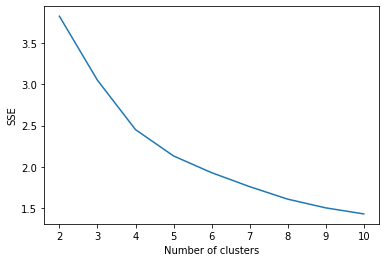

In [178]:
plt.plot(range(2,11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [179]:
# From above chart, k=6 seems to give resonable accuracy
# Build model again using k=6
kclusters = 6
seoul_grouped_clustering = seoul_grouped_mean.drop('Neighborhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seoul_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([4, 2, 0, 0, 2, 0, 4, 4, 1, 4, 1, 0, 2, 0, 1, 5, 3, 2, 0, 3])

## Add label to neighborhood dataframe

In [180]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [181]:
seoul_merged = seoul_data

#seoul_grouped with seoul_data to add latitude/longitude for each neighborhood
seoul_merged = seoul_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seoul_merged.head() 

,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
673,서울특별시,강서구,등촌동,공항대로58나길,힐하우스,7666,970,126.862080,37.549676,힐하우스_7666,4,Food and drink,Sightseeing and culture,Service and store,Transport,Entertainment,Lodging,Sports and leisure
378,서울특별시,중랑구,상봉동,신내로7다길,상봉빌라,2079,2295,127.091766,37.603401,상봉빌라_2079,5,Food and drink,Service and store,Transport,Entertainment,Sports and leisure,Lodging,Sightseeing and culture
118,서울특별시,중구,신당동,동호로8나길,신당힐빌리지,4594,840,127.014236,37.552235,신당힐빌리지_4594,4,Food and drink,Sports and leisure,Sightseeing and culture,Service and store,Entertainment,Lodging,Transport
747,서울특별시,강서구,공항동,공항대로,우성빌딩,7623,1335,126.812512,37.558736,우성빌딩_7623,5,Food and drink,Service and store,Transport,Entertainment,Sightseeing and culture,Sports and leisure,Lodging
8,서울특별시,종로구,누상동,필운대로5가길,창원예가,3037,2865,126.966781,37.580645,창원예가_3037,4,Food and drink,Sightseeing and culture,Service and store,Sports and leisure,Entertainment,Lodging,Transport


## Visualize the resulting cluster

In [185]:
latitude = 37.5665
longitude = 126.9780

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seoul_merged['Latitude'], seoul_merged['Longitude'], seoul_merged['Neighborhood'], seoul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine clusters

## Cluster 1 - Service hub and sight-seeing lover
### You can easily find all kind of services and stores near here!
### Also there are a lot of sight-seeing & culture sites which you can visit!

In [186]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 0, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
892,관악구,8714,640,126.945216,37.489183,정우빌라_8714,0,Food and drink,Transport,Entertainment,Lodging,Service and store,Sightseeing and culture,Sports and leisure
922,관악구,8740,2730,126.962425,37.481875,한성빌라_8740,0,Food and drink,Sports and leisure,Sightseeing and culture,Entertainment,Service and store,Lodging,Transport
627,마포구,3980,1695,126.925179,37.564834,동국빌라_3980,0,Food and drink,Service and store,Lodging,Sightseeing and culture,Sports and leisure,Entertainment,Transport
697,강서구,7755,1020,126.850419,37.532399,소망빌라_7755,0,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport
639,양천구,8060,1250,126.850076,37.518104,현대빌리지_8060,0,Food and drink,Sightseeing and culture,Sports and leisure,Entertainment,Lodging,Service and store,Transport
974,서초구,6677,1670,126.986323,37.481208,진우빌라_6677,0,Food and drink,Service and store,Entertainment,Sightseeing and culture,Sports and leisure,Lodging,Transport
993,서초구,6579,1535,127.002681,37.496871,효성빌라_6579,0,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
822,영등포구,7379,1430,126.898289,37.502376,성원아파트_7379,0,Food and drink,Entertainment,Service and store,Sightseeing and culture,Sports and leisure,Lodging,Transport
519,도봉구,1458,1045,127.035787,37.645519,삼보빌라_1458,0,Food and drink,Service and store,Sightseeing and culture,Entertainment,Lodging,Sports and leisure,Transport
817,영등포구,7431,760,126.915462,37.498207,세원빌라_7431,0,Food and drink,Sports and leisure,Transport,Sightseeing and culture,Entertainment,Lodging,Service and store


## Cluster 2 - Sport enthusiasm, pro or amateur!
### Heaven for sport lovers

In [187]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 1, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
496,도봉구,1448,2335,127.031256,37.646171,드림하우스_1448,1,Food and drink,Sightseeing and culture,Service and store,Sports and leisure,Entertainment,Lodging,Transport
439,강북구,1162,1665,127.029778,37.622958,타임아트빌_1162,1,Food and drink,Service and store,Entertainment,Sightseeing and culture,Sports and leisure,Lodging,Transport
243,성동구,4805,1970,127.054968,37.562144,아이나라놀이방_4805,1,Food and drink,Lodging,Sports and leisure,Transport,Service and store,Entertainment,Sightseeing and culture
552,은평구,3346,865,126.929462,37.622559,수정빌라_3346,1,Food and drink,Service and store,Entertainment,Lodging,Sightseeing and culture,Sports and leisure,Transport
436,강북구,1233,2090,127.033269,37.616419,장안빌라_1233,1,Food and drink,Service and store,Sightseeing and culture,Sports and leisure,Entertainment,Transport,Lodging
113,중구,4600,1285,127.007547,37.549800,약수 준아트빌_4600,1,Food and drink,Sports and leisure,Sightseeing and culture,Entertainment,Service and store,Lodging,Transport
194,용산구,4384,2190,126.992302,37.523488,그린파크아파트_4384,1,Food and drink,Service and store,Sports and leisure,Sightseeing and culture,Transport,Entertainment,Lodging
451,강북구,1142,1855,127.030940,37.627415,홍익빌라_1142,1,Food and drink,Sports and leisure,Service and store,Entertainment,Sightseeing and culture,Lodging,Transport
91,중구,4618,1560,127.002069,37.559438,장수빌라_4618,1,Food and drink,Lodging,Sports and leisure,Entertainment,Sightseeing and culture,Service and store,Transport
866,동작구,7030,2445,126.968140,37.487757,법성사_7030,1,Food and drink,Sports and leisure,Sightseeing and culture,Transport,Entertainment,Lodging,Service and store


## Cluster 3 - Walk around & play!
### Sight-seeing, culture activities, historical site, entertainment all in one!

In [188]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 2, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
79,종로구,3013,1585,126.957494,37.602717,정은맨션_3013,2,Food and drink,Sightseeing and culture,Transport,Entertainment,Service and store,Lodging,Sports and leisure
72,종로구,3020,1050,126.965929,37.597301,승림힐스빌리지_3020,2,Food and drink,Sightseeing and culture,Transport,Service and store,Sports and leisure,Entertainment,Lodging
23,종로구,3057,2825,126.988508,37.582543,삼정빌라_3057,2,Food and drink,Sightseeing and culture,Entertainment,Service and store,Lodging,Sports and leisure,Transport
713,강서구,7677,1305,126.849066,37.543185,밀레니엄_7677,2,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport
724,강서구,7723,1855,126.849838,37.539319,가온누리_7723,2,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport
71,종로구,3017,2935,126.960660,37.598851,시아부암아이윌_3017,2,Food and drink,Sightseeing and culture,Transport,Entertainment,Service and store,Sports and leisure,Lodging
295,광진구,4938,1010,127.087467,37.570570,한진아트빌라_4938,2,Food and drink,Sightseeing and culture,Transport,Entertainment,Lodging,Service and store,Sports and leisure
715,강서구,7662,1945,126.852587,37.546420,덕수궁_7662,2,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport
686,강서구,7751,2635,126.846581,37.534056,대한빌라_7751,2,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport
325,광진구,4993,2170,127.089128,37.550504,현대빌라_4993,2,Food and drink,Sightseeing and culture,Sports and leisure,Entertainment,Service and store,Lodging,Transport


## Cluster 4 - All around
### A lot of sight-seeing place + convenience transportation + sport centers + service center, you can find all here!

In [189]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 3, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
444,강북구,1182,2820,127.015107,37.625276,다우빌라_1182,3,Food and drink,Transport,Sightseeing and culture,Sports and leisure,Entertainment,Lodging,Service and store
464,강북구,1147,575,127.034185,37.628591,유진빌라_1147,3,Food and drink,Sports and leisure,Sightseeing and culture,Service and store,Entertainment,Lodging,Transport
795,금천구,8567,2795,126.908215,37.460583,리더스빌_8567,3,Food and drink,Sports and leisure,Service and store,Transport,Entertainment,Lodging,Sightseeing and culture
292,광진구,4941,1335,127.088368,37.566559,베네시티_4941,3,Food and drink,Transport,Sightseeing and culture,Service and store,Sports and leisure,Entertainment,Lodging
463,강북구,1149,920,127.033699,37.627233,서광빌라_1149,3,Food and drink,Sightseeing and culture,Sports and leisure,Service and store,Entertainment,Lodging,Transport
928,관악구,8854,910,126.924236,37.470175,서원빌라_8854,3,Food and drink,Transport,Sports and leisure,Sightseeing and culture,Entertainment,Lodging,Service and store
489,강북구,1031,2485,127.010777,37.644375,라온하우스_1031,3,Food and drink,Sightseeing and culture,Sports and leisure,Transport,Lodging,Service and store,Entertainment
483,강북구,1096,2275,127.009100,37.628180,대영빌라_1096,3,Food and drink,Sightseeing and culture,Sports and leisure,Transport,Entertainment,Lodging,Service and store
579,서대문구,3633,1145,126.950673,37.582961,로얄아파트_3633,3,Food and drink,Sightseeing and culture,Sports and leisure,Transport,Entertainment,Lodging,Service and store
487,강북구,1031,1060,127.011500,37.643658,세영아트빌_1031,3,Food and drink,Sightseeing and culture,Sports and leisure,Transport,Lodging,Service and store,Entertainment


## Cluster 5 - Sport lovers and sightseeing goers
### A lot of sport centers & sightseeing area close by!

In [190]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 4, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
673,강서구,7666,970,126.862080,37.549676,힐하우스_7666,4,Food and drink,Sightseeing and culture,Service and store,Transport,Entertainment,Lodging,Sports and leisure
118,중구,4594,840,127.014236,37.552235,신당힐빌리지_4594,4,Food and drink,Sports and leisure,Sightseeing and culture,Service and store,Entertainment,Lodging,Transport
8,종로구,3037,2865,126.966781,37.580645,창원예가_3037,4,Food and drink,Sightseeing and culture,Service and store,Sports and leisure,Entertainment,Lodging,Transport
39,종로구,3074,2485,126.998263,37.585939,예성빌라_3074,4,Food and drink,Sightseeing and culture,Entertainment,Service and store,Lodging,Sports and leisure,Transport
43,종로구,3065,1810,126.994445,37.591331,힐하우스_3065,4,Food and drink,Sightseeing and culture,Entertainment,Sports and leisure,Lodging,Service and store,Transport
44,종로구,3073,1165,126.995139,37.585308,인덕주택_3073,4,Food and drink,Sightseeing and culture,Entertainment,Service and store,Lodging,Sports and leisure,Transport
412,성북구,2821,2345,127.003328,37.599410,에이스빌라_2821,4,Food and drink,Sightseeing and culture,Service and store,Sports and leisure,Transport,Entertainment,Lodging
63,종로구,3010,2695,126.975877,37.609783,동우빌라_3010,4,Food and drink,Sightseeing and culture,Sports and leisure,Transport,Entertainment,Lodging,Service and store
701,강서구,7720,1295,126.841779,37.537323,삼성쉐르빌_7720,4,Food and drink,Sightseeing and culture,Entertainment,Transport,Lodging,Service and store,Sports and leisure
339,광진구,5025,2735,127.081852,37.540547,삼성홈타운_5025,4,Food and drink,Service and store,Sightseeing and culture,Entertainment,Sports and leisure,Lodging,Transport


## Group 6 - Transportation hub and a convenience life
### Bus station, train station, metro close by 
### Also a lot of service and store ==> what a convenience life!

In [191]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 5, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
378,중랑구,2079,2295,127.091766,37.603401,상봉빌라_2079,5,Food and drink,Service and store,Transport,Entertainment,Sports and leisure,Lodging,Sightseeing and culture
747,강서구,7623,1335,126.812512,37.558736,우성빌딩_7623,5,Food and drink,Service and store,Transport,Entertainment,Sightseeing and culture,Sports and leisure,Lodging
589,서대문구,3649,2895,126.933475,37.595419,삼성빌라_3649,5,Food and drink,Service and store,Sports and leisure,Transport,Lodging,Sightseeing and culture,Entertainment
556,은평구,3351,1975,126.923999,37.617811,우성리치빌_3351,5,Food and drink,Service and store,Transport,Entertainment,Sightseeing and culture,Lodging,Sports and leisure
248,광진구,4908,2360,127.081780,37.566748,신영아트빌_4908,5,Food and drink,Transport,Service and store,Sightseeing and culture,Entertainment,Lodging,Sports and leisure
531,노원구,1887,815,127.058422,37.624908,삼정빌라_1887,5,Food and drink,Transport,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture
768,구로구,8254,2580,126.837456,37.495767,우정빌라_8254,5,Food and drink,Lodging,Service and store,Transport,Entertainment,Sightseeing and culture,Sports and leisure
121,중구,4575,615,127.022546,37.567214,황학동 코아루_4575,5,Food and drink,Sightseeing and culture,Entertainment,Transport,Lodging,Service and store,Sports and leisure
366,중랑구,2142,1115,127.083055,37.591673,현대빌라_2142,5,Food and drink,Transport,Service and store,Entertainment,Sightseeing and culture,Lodging,Sports and leisure
778,금천구,8548,1145,126.910105,37.479079,에이스빌_8548,5,Food and drink,Transport,Lodging,Service and store,Sightseeing and culture,Entertainment,Sports and leisure


# Example for choosing a living place in Seoul

In [201]:
# Example 1
# Customer is a sport lover with a budget of 2000$/month for renting a house and want to live in 강북구
cus_group = 2      # sport lover group
cus_rent = 2000    # max 2000$/month
cus_loc = '강북구'  # district selected

cus_data = seoul_merged[(seoul_merged['Cluster Labels']==(cus_group-1)) & (seoul_merged['RentPrice']<=cus_rent) & (seoul_merged['District']==cus_loc)]

print('Number of place = ',len(cus_data))
cus_data.head(100)

Number of place =  3


,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
439,서울특별시,강북구,미아동,도봉로30길,타임아트빌,1162,1665,127.029778,37.622958,타임아트빌_1162,1,Food and drink,Service and store,Entertainment,Sightseeing and culture,Sports and leisure,Lodging,Transport
451,서울특별시,강북구,미아동,오패산로52바길,홍익빌라,1142,1855,127.030940,37.627415,홍익빌라_1142,1,Food and drink,Sports and leisure,Service and store,Entertainment,Sightseeing and culture,Lodging,Transport
488,서울특별시,강북구,수유동,인수봉로73나길,홍익빌라,1020,1325,127.007724,37.642437,홍익빌라_1020,1,Food and drink,Sports and leisure,Sightseeing and culture,Transport,Lodging,Service and store,Entertainment


## Show these places on the map

In [208]:
cus_data['Latitude']

439    37.622958
451    37.627415
488    37.642437
Name: Latitude, dtype: float64

In [212]:
import folium

latitude = 37.5665
longitude = 126.9780

map_cus = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cus_data['Latitude'], cus_data['Longitude'], cus_data['BuildingName'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
       ).add_to(map_cus)
map_cus

In [215]:
# Example 2
# Customer love sight-seeing & entertainment with a budget of 1500$/month for renting a house and want to live in 강서구
cus_group = 3      # sport lover group
cus_rent = 1500    # max 2000$/month
cus_loc = '강서구'  # district selected

cus_data = seoul_merged[(seoul_merged['Cluster Labels']==(cus_group-1)) & (seoul_merged['RentPrice']<=cus_rent) & (seoul_merged['District']==cus_loc)]

print('Number of place = ',len(cus_data))
cus_data.head(100)

Number of place =  4


,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
713,서울특별시,강서구,화곡동,까치산로14길,밀레니엄,7677,1305,126.849066,37.543185,밀레니엄_7677,2,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport
725,서울특별시,강서구,화곡동,초록마을로22길,금산빌라,7725,985,126.849458,37.537411,금산빌라_7725,2,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport
714,서울특별시,강서구,화곡동,까치산로18라길,한강맨션,7661,790,126.853927,37.544470,한강맨션_7661,2,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport
682,서울특별시,강서구,화곡동,초록마을로,삼성빌라,7724,1060,126.851367,37.539135,삼성빌라_7724,2,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport


In [217]:
import folium

latitude = 37.5665
longitude = 126.9780

map_cus = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cus_data['Latitude'], cus_data['Longitude'], cus_data['BuildingName'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
       ).add_to(map_cus)
map_cus

# Customized profile selection

## For customers who do not fall into any of 6 above groups

## A customized profile will be built

In [258]:
# Example customer manual profile 1

lv_food = 100              # food and drink
lv_sightSeeing = 100       # sight-seeing and culture
lv_service = 80            # service and shop
lv_sport = 40              # sport and leisure
lv_entertain = 20          # entertainment
lv_lodging = 10            # lodging
lv_transport = 80          # trasportation

cus_rent = 2000    # max 2000$/month

In [264]:
# normalize these values
lv_total = lv_food + lv_sightSeeing + lv_service + lv_sport + lv_entertain + lv_lodging + lv_transport

# Customer profile setting
cus_profile = [lv_entertain / lv_total, lv_food / lv_total, lv_lodging / lv_total,lv_service / lv_total, lv_sightSeeing / lv_total, lv_sport / lv_total, lv_transport/lv_total]
cus_profile

[0.046511627906976744,
 0.23255813953488372,
 0.023255813953488372,
 0.18604651162790697,
 0.23255813953488372,
 0.09302325581395349,
 0.18604651162790697]

In [224]:
# Compare with seoul_grouped_mean to get a best matched
seoul_grouped_dis = seoul_grouped_mean.drop(columns=['Neighborhood'],axis=1)
seoul_grouped_dis.head()

,Entertainment,Food and drink,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
0,0.000000,0.815789,0.0,0.000000,0.078947,0.078947,0.026316
1,0.000000,0.733333,0.0,0.000000,0.266667,0.000000,0.000000
2,0.041667,0.833333,0.0,0.000000,0.083333,0.041667,0.000000
3,0.035714,0.857143,0.0,0.035714,0.035714,0.017857,0.017857
4,0.066667,0.666667,0.0,0.000000,0.266667,0.000000,0.000000


## Calculate Minkowski distance to find similarity in profile

In [261]:
from scipy.spatial import distance

seoul_grouped_mean['Mindis'] = 0 # to save the minkowski distance

# Calculate minkowski distance
for i in range(len(seoul_grouped_dis)):
    seoul_grouped_mean.loc[i, 'Mindis'] = distance.minkowski(seoul_grouped_dis.iloc[i].values,cus_profile,1)

seoul_mean_merged = seoul_data

# merge seoul_mean with seoul_data to add distance for each neighborhood
seoul_mean_merged = seoul_mean_merged.join(seoul_grouped_mean.set_index('Neighborhood'), on='Neighborhood')

# sort value to get the lowest minkowski distance 
seoul_mean_sorted = seoul_mean_merged.sort_values(by = 'Mindis')

# get only row with rent price less than customer given value
cus_data = seoul_mean_sorted[seoul_mean_sorted['RentPrice']<=cus_rent]

print('Number of place = ',len(cus_data))
cus_data = cus_data.head(10)
cus_data.head()

Number of place =  130


,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Entertainment,Food and drink,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport,Mindis
292,서울특별시,광진구,중곡동,용마산로22길,베네시티,4941,1335,127.088368,37.566559,베네시티_4941,0.000000,0.375000,0.000000,0.125000,0.187500,0.062500,0.250000,0.412791
579,서울특별시,서대문구,홍제동,통일로26길,로얄아파트,3633,1145,126.950673,37.582961,로얄아파트_3633,0.000000,0.357143,0.000000,0.000000,0.357143,0.142857,0.142857,0.598007
487,서울특별시,강북구,수유동,인수봉로72길,세영아트빌,1031,1060,127.011500,37.643658,세영아트빌_1031,0.000000,0.500000,0.038462,0.038462,0.192308,0.115385,0.115385,0.610018
463,서울특별시,강북구,번동,오현로25다길,서광빌라,1149,920,127.033699,37.627233,서광빌라_1149,0.047619,0.476190,0.000000,0.095238,0.190476,0.190476,0.000000,0.684385
464,서울특별시,강북구,번동,오현로25마길,유진빌라,1147,575,127.034185,37.628591,유진빌라_1147,0.055556,0.444444,0.000000,0.111111,0.166667,0.222222,0.000000,0.700258


## Show top 10 places on the map

In [262]:
import folium

latitude = 37.5665
longitude = 126.9780

map_cus = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cus_data['Latitude'], cus_data['Longitude'], cus_data['BuildingName'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
       ).add_to(map_cus)
map_cus

In [267]:
# Example customer manual profile 2

lv_food = 100              # food and drink
lv_sightSeeing = 20       # sight-seeing and culture
lv_service = 20            # service and shop
lv_sport = 100              # sport and leisure
lv_entertain = 100          # entertainment
lv_lodging = 100            # lodging
lv_transport = 20          # trasportation

cus_rent = 2000    # max 2000$/month

In [268]:
# normalize these values
lv_total = lv_food + lv_sightSeeing + lv_service + lv_sport + lv_entertain + lv_lodging + lv_transport

# Customer profile setting
cus_profile = [lv_entertain / lv_total, lv_food / lv_total, lv_lodging / lv_total,lv_service / lv_total, lv_sightSeeing / lv_total, lv_sport / lv_total, lv_transport/lv_total]
cus_profile

[0.21739130434782608,
 0.21739130434782608,
 0.21739130434782608,
 0.043478260869565216,
 0.043478260869565216,
 0.21739130434782608,
 0.043478260869565216]

In [269]:
from scipy.spatial import distance

seoul_grouped_mean['Mindis'] = 0 # to save the minkowski distance

# Calculate minkowski distance
for i in range(len(seoul_grouped_dis)):
    seoul_grouped_mean.loc[i, 'Mindis'] = distance.minkowski(seoul_grouped_dis.iloc[i].values,cus_profile,1)

seoul_mean_merged = seoul_data

# merge seoul_mean with seoul_data to add distance for each neighborhood
seoul_mean_merged = seoul_mean_merged.join(seoul_grouped_mean.set_index('Neighborhood'), on='Neighborhood')

# sort value to get the lowest minkowski distance 
seoul_mean_sorted = seoul_mean_merged.sort_values(by = 'Mindis')

# get only row with rent price less than customer given value
cus_data = seoul_mean_sorted[seoul_mean_sorted['RentPrice']<=cus_rent]

print('Number of place = ',len(cus_data))
cus_data = cus_data.head(10)
cus_data.head()

Number of place =  130


,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Entertainment,Food and drink,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport,Mindis
464,서울특별시,강북구,번동,오현로25마길,유진빌라,1147,575,127.034185,37.628591,유진빌라_1147,0.055556,0.444444,0.000000,0.111111,0.166667,0.222222,0.000000,0.845411
451,서울특별시,강북구,미아동,오패산로52바길,홍익빌라,1142,1855,127.030940,37.627415,홍익빌라_1142,0.055556,0.500000,0.000000,0.166667,0.055556,0.222222,0.000000,0.845411
243,서울특별시,성동구,용답동,용답27길,아이나라놀이방,4805,1970,127.054968,37.562144,아이나라놀이방_4805,0.000000,0.590909,0.136364,0.045455,0.000000,0.136364,0.090909,0.845850
780,서울특별시,금천구,독산동,독산로74길,현대하이츠빌라,8557,1365,126.906478,37.468233,현대하이츠빌라_8557,0.050000,0.500000,0.100000,0.150000,0.000000,0.100000,0.100000,0.891304
488,서울특별시,강북구,수유동,인수봉로73나길,홍익빌라,1020,1325,127.007724,37.642437,홍익빌라_1020,0.000000,0.600000,0.040000,0.040000,0.080000,0.160000,0.080000,0.911304


## Show top 10 place on the map

In [271]:
import folium

latitude = 37.5665
longitude = 126.9780

map_cus = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cus_data['Latitude'], cus_data['Longitude'], cus_data['BuildingName'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
       ).add_to(map_cus)
map_cus